# Chain-based sequence propagation in conductance-based LIF network

Demo of stable sequence propagation where strength of inhibitory feedback controls propagation speed.

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import sys

import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy.ndimage import gaussian_filter1d as smooth
from scipy.sparse import csc_matrix

from aux import Generic
from disp import set_font_size, set_color, set_n_x_ticks
from ntwk import LIFNtwkG, join_w

cc = np.concatenate

# PARAMS
## MODEL
M = {
    # E membrane dynamics
    'C_M_E': 1e-6, 'G_L_E': .1e-3, 'E_L_E': -0.05, 'V_TH_E': -0.036, 'V_R_E': -0.05, 'T_R_E': 0.002,
    # E architecture
    'N_E': 6000, 'N_X': 14, 'DX': .035,  # total E cells and chain params
    'W_E_E': .055e-3, 'W_MIN_E_E': .001e-4, 'L_E_E_F': 0.03,  # feed forward chain cxns
    'W_E_A': .0575e-3,  # adaptation (represented by inhibitory autapses)
    
    # I membrane dynamics
    'C_M_I': 1e-6, 'G_L_I': .2e-3, 'E_L_I': -0.06, 'V_TH_I': -0.05, 'V_R_I': -0.06, 'T_R_I': 0.002,
    # I architecture
    'N_I': 750, 'P_I_E': .5, 'P_E_I': .5, 'W_I_E': 2e-6, 'W_E_I': .9e-6,  # interactions w E cells
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.002,
    'E_A': -0.1, 'T_A': 0.01,  # adaptation 
}


## SMLN
S = {
    'RNG_SEED': 0, 'DT': 0.0005, 'D_SMLN': 1,
    'TRG': {'T': 0.05, 'A': 1e-4, 'R': 0.001, 'D': 0.005, 'X': 0},
    'NOISE': 0,  #.2e-6,
}

print('TAU_M_E = {:.1f} ms'.format(M['C_M_E']/M['G_L_E'] * 1e3))
print('TAU_M_I = {:.1f} ms'.format(M['C_M_I']/M['G_L_I'] * 1e3))

TAU_M_E = 10.0 ms
TAU_M_I = 5.0 ms


$\tau^m_E = 10$ ms

$\tau^m_I = 5$ ms

$\tau_E = 2$ ms

$\tau_I = 2$ ms

Chain position assignment and connectivity

In [2]:
# plot func
def get_idxs_nearest(x_seq, x, nearest):
    """
    Get ordered idxs of place fields nearest to a sequence of xs.
    """
    idxs = []
    
    for x_ in x_seq:
        # get dists of all xs in x_seq to x
        dx = x - x_
        
        # add idxs of closest neurons to list
        idxs_ = list(np.abs(dx).argsort()[:nearest])
        idxs.extend(idxs_)
        
    return idxs

# connectivity funcs
def assign_x(dx, n_x, n, randomize):
    
    # number of layers
    n_l = int(round(n/n_x))
    
    # cells per layer
    n_xs = np.array([len(_) for _ in np.array_split(np.arange(n), n_l)])

    # interleave layer counts to prevent heavier layers bunching at start
    idx_c = np.nan * np.zeros(n_l)

    for n_x_ in np.unique(n_xs):
        mask = n_xs == n_x_
        idx_c[mask] = np.linspace(0, 1, mask.sum()+2)[1:-1]
    n_xs = n_xs[np.argsort(idx_c)]

    # assign x positions
    x = cc([np.repeat(dx*x_ctr, n_xs[x_ctr]) for x_ctr in range(len(n_xs))])
    
    if randomize:
        x = x[np.random.permutation(n)]
        
    return x

def make_w_e_e(x, m):
    """Make E-E weight mat w/ weight increasing w/ proxim."""
    n_e = m['N_E']
    
    # build distance matrix
    dx = np.tile(x[:, None], (1, n_e)) - np.tile(x[None, :], (n_e, 1))
    
    # build weight matrix
    ## decrease weights as squared exp of dist
    w = np.zeros(dx.shape)
    mask_f = dx >= 0  # forward cxns
    w[mask_f] = m['W_E_E'] * np.exp(-dx[mask_f]**2/(2*m['L_E_E_F']**2))
    ## set all weights below min weight th to 0
    w[w < m['W_MIN_E_E']] = 0
    
    return w

def make_w_i_e(m):
    """
    Make proximally biased E->I weight matrix.
    """
    n_i = m['N_I']
    n_e = m['N_E']
    
    # build weight matrix
    w_i_e = m['W_I_E'] * (np.random.rand(n_i, n_e) < m['P_I_E']).astype(float)
    return w_i_e
    
def make_w_e_i(m):
    """
    Make center-surround structured I->E weight matrix.
    """
    n_e = m['N_E']
    n_i = m['N_I']
    
    # build weight matrix
    w_e_i = m['W_E_I'] * (np.random.rand(n_e, n_i) < m['P_E_I']).astype(float)
    return w_e_i

def build_ntwk(m, s):
    """
    Construct a network object from the model and
    simulation params.
    """
    np.random.seed(s['RNG_SEED'])
    
    # set membrane properties
    n = m['N_E'] + m['N_I']
    
    c_m = cc(
        [np.repeat(m['C_M_E'], m['N_E']), np.repeat(m['C_M_I'], m['N_I'])])
    g_l = cc(
        [np.repeat(m['G_L_E'], m['N_E']), np.repeat(m['G_L_I'], m['N_I'])])
    e_l = cc(
        [np.repeat(m['E_L_E'], m['N_E']), np.repeat(m['E_L_I'], m['N_I'])])
    v_th = cc(
        [np.repeat(m['V_TH_E'], m['N_E']), np.repeat(m['V_TH_I'], m['N_I'])])
    v_r = cc(
        [np.repeat(m['V_R_E'], m['N_E']), np.repeat(m['V_R_I'], m['N_I'])])
    t_r = cc(
        [np.repeat(m['T_R_E'], m['N_E']), np.repeat(m['T_R_I'], m['N_I'])])
    
    # assign chain positions (x) to E cells
    x_e = assign_x(m['DX'], m['N_X'], m['N_E'], randomize=True)
    x = cc([x_e, np.zeros(m['N_I'])])
    
    w_u = {'E': np.zeros((m['N_E'] + m['N_I'], 0))}  # no upstream spike inputs
    
    # make rcr ws
    targs_r = cc([np.repeat('E', m['N_E']), np.repeat('I', m['N_I'])])
    
    w_e_e = make_w_e_e(x[:m['N_E']], m)
    w_i_e = make_w_i_e(m)
    w_e_i = make_w_e_i(m)
    
    w_e_a = m['W_E_A'] * np.eye(m['N_E'])
    
    w_r_temp = {
        'E': {('E', 'E'): w_e_e, ('I', 'E'): w_i_e},
        'I': {('E', 'I'): w_e_i},
        'A': {('E', 'E'): w_e_a},
    }
    
    w_r = join_w(targs_r, targs_r, w_r_temp)
    
    # make ntwk
    ntwk = LIFNtwkG(
        c_m=c_m,
        g_l=g_l,
        e_l=e_l,
        v_th=v_th,
        v_r=v_r,
        t_r=t_r,
        e_s={'E': m['E_E'], 'I': m['E_I'], 'A': m['E_A']},
        t_s={'E': m['T_E'], 'I': m['T_I'], 'A': m['T_A']},
        w_r=w_r,
        w_u=w_u)
    
    ntwk.x = x
    
    ntwk.types_r = targs_r
    
    ntwk.n_e = m['N_E']
    ntwk.n_i = m['N_I']
    ntwk.n = m['N_E'] + m['N_I']
    
    return ntwk

def i_ext_trg(t, ntwk, m, s):
    """
    Add replay trigger to external current stim.
    """
    i_ext = np.zeros((len(t), m['N_E'] + m['N_I']))
    
    # get mask over cells to trigger to induce replay
    ## compute distances to trigger center
    dx = ntwk.x - s['TRG']['X']

    ## get mask
    trg_mask = (np.abs(dx) < s['TRG']['R']) & (ntwk.types_r == 'E')

    ## get time mask
    t_mask = (s['TRG']['T'] <= t) \
        & (t < (s['TRG']['T'] + s['TRG']['D']))

    ## add in external trigger
    i_ext[np.outer(t_mask, trg_mask)] = s['TRG']['A']

    return i_ext

# Speed control via recurrent inhibition

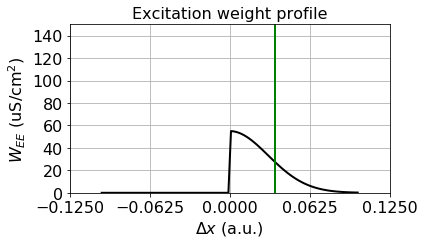

In [3]:
# plot connectivity profile
dx = np.linspace(-.1, .1, 100)
w = np.zeros(dx.shape)
mask_f = dx >= 0  # forward cxns
w[mask_f] = M['W_E_E'] * np.exp(-dx[mask_f]**2/(2*M['L_E_E_F']**2))
## set all weights below min weight th to 0
w[w < M['W_MIN_E_E']] = 0

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5), tight_layout=True)
ax.plot(dx, w*1e6, c='k', lw=2)
ax.axvline(M['DX'], c='g', lw=2)
ax.set_ylim(0, 150)
ax.set_xlabel(r'$\Delta x$ (a.u.)')
ax.set_ylabel(r'$W_{EE}$ (uS/cm$^2$)')
ax.set_title('Excitation weight profile')
ax.grid()
set_n_x_ticks(ax, 5)
set_font_size(ax, 16)

In [4]:
m = copy(M)
s = copy(S)

w_e_is = [0, .9e-6]
rslts = []
rslt_c = [(0, 1, 0), (0, .5, 0), (0, 0, 0)]

for w_e_i in w_e_is:
    m['W_E_I'] = w_e_i

    print('Running smln with W_E_I = {:.2f} uS/cm^2...'.format(w_e_i*1e6))
    
    t = np.arange(0, s['D_SMLN'], s['DT'])
    
    ## build ntwk
    ntwk = build_ntwk(m, s)
   
    # initialize external current array
    i_ext = np.zeros((len(t), m['N_E'] + m['N_I']))
    
    # add replay trigger
    i_ext += i_ext_trg(t, ntwk, m, s)
    
    # run smln
    clamp = Generic(
        v={0: cc([np.repeat(m['E_L_E'], m['N_E']), np.repeat(m['E_L_I'], m['N_I'])])}, spk={})
    rslt = ntwk.run(i_ext=i_ext, clamp=clamp, dt=s['DT'])
    
    # consolidate smln rslt
    rslt.ntwk = ntwk
    rslt.trg = s['TRG']
    
    rslt.m = m
    rslt.s = s
    
    rslts.append(rslt)

Running smln with W_E_I = 0.00 uS/cm^2...
Running smln with W_E_I = 0.90 uS/cm^2...


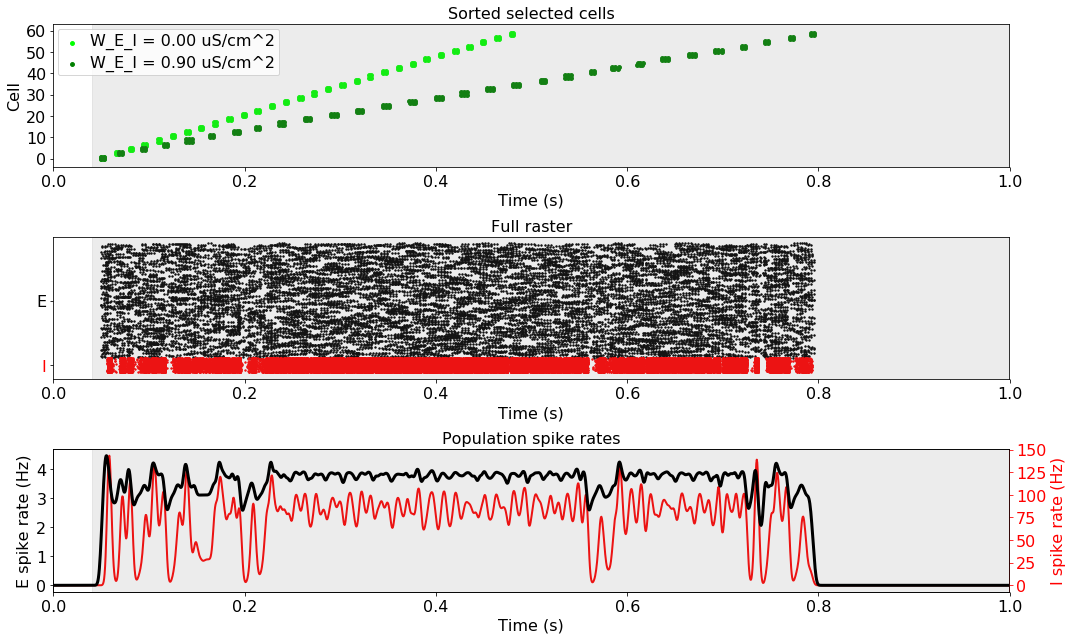

In [5]:
# make plots
X_RASTER = np.linspace(0, rslt.ntwk.x.max(), 30)
EPOCH = (.04, 1.)

colors=np.zeros(len(X_RASTER))
cmap='inferno'
nearest=2
epoch=(0, 1)
smoothness=4
fig_size=(15, 9)

fig, axs = plt.subplots(3, 1, figsize=fig_size, tight_layout=True)

for rslt, c in zip(rslts, rslt_c):
    # get ordered idxs of Es to plot
    e_mask = rslt.ntwk.types_r == 'E'
    x = rslt.ntwk.x[e_mask]

    ## loop through (x, y) pairs and add idxs of nearest Es
    e_idxs = get_idxs_nearest(X_RASTER, x, nearest) 

    # get all spks for selected Es
    spks_e_chosen = rslt.spks[:, e_idxs]

    # get desired time window
    if epoch == 'replay':
        start = 0
        end = rslt.schedule['D_SMLN']
    elif isinstance(epoch, tuple):
        start = epoch[0]
        end = epoch[1]

    t_mask = (start <= rslt.t) & (rslt.t < end)
    t_start = rslt.t[t_mask][0]

    spk_t_idxs, es = spks_e_chosen[t_mask].nonzero()
    spk_ts = spk_t_idxs * rslt.s['DT'] + t_start

    ## spks
    axs[0].scatter(spk_ts, es, c=c, s=15, vmin=0, vmax=1, cmap=cmap)

axs[0].set_xlim(0, rslt.t[-1])
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Cell')
axs[0].set_title('Sorted selected cells')
axs[0].legend(['W_E_I = {:.2f} uS/cm^2'.format(w_e_i*1e6) for w_e_i in w_e_is])

set_font_size(axs[0], 16)

rslt = rslts[-1]

# Es
## get spks
spks_e = rslt.spks[:, :rslt.m['N_E']]

## raster
t_idxs_spks_e, nrn_spks_e = spks_e.nonzero()
t_spks_e = t_idxs_spks_e * rslt.dt

axs[1].scatter(t_spks_e, nrn_spks_e, s=2, c='k')

# population firing rate
axs[2].plot(rslt.t, smooth(spks_e.sum(axis=1) / (rslt.dt * rslt.m['N_E']), smoothness), c='k', lw=3)
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('E spike rate (Hz)')
axs[2].set_title('Population spike rates')

# Is
# get spks
spks_i = rslt.spks[:, -rslt.m['N_I']:]

# raster
t_idxs_spks_i, nrn_spks_i = spks_i.nonzero()
t_spks_i = t_idxs_spks_i * rslt.dt

axs[1].scatter(t_spks_i, -(1 + nrn_spks_i), s=2, c='r')
axs[1].set_yticks([-rslt.m['N_I']/2, rslt.m['N_E']/2])
axs[1].set_yticklabels(['I', 'E'])
axs[1].set_xlabel('Time (s)')
axs[1].set_title('Full raster')

for tick_label, color in zip(axs[1].get_yticklabels(), ['r', 'k']):
    tick_label.set_color(color)

# inh population average
ax_2_twin = axs[2].twinx()
ax_2_twin.plot(rslt.t, smooth(spks_i.sum(axis=1) / (rslt.dt * rslt.m['N_I']), smoothness), c='r', lw=2)
ax_2_twin.set_ylabel('I spike rate (Hz)')

axs[2].set_zorder(ax_2_twin.get_zorder() + 1)
axs[2].patch.set_visible(False)

set_color(ax_2_twin, 'r')

for ax in list(axs[1:]) + [ax_2_twin]:
    ax.set_xlim(0, rslt.t[-1])
    set_font_size(ax, 16)
    
axs[0].axvspan(*EPOCH, color='gray', alpha=0.15)
axs[1].axvspan(*EPOCH, color='gray', alpha=0.15)
axs[2].axvspan(*EPOCH, color='gray', alpha=0.15);

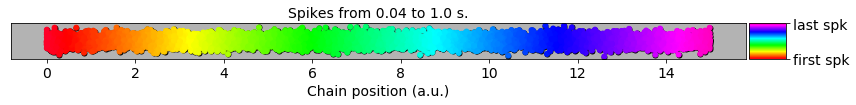

In [6]:
epoch = EPOCH
cmap='gist_rainbow'
sct_sz=25

fig, ax = plt.subplots(1, 1, figsize=(12, 3), tight_layout=True)

## detection wdw
start = epoch[0]
end = epoch[1]

t_mask = (start <= rslt.t) & (rslt.t < end)

e_mask = rslt.ntwk.types_r == 'E'

x_e = rslt.ntwk.x[e_mask]
y_e = np.random.normal(0, .1, len(x_e))

## E spk cts within detection window
spks_wdw_e = rslt.spks[t_mask][:, e_mask]
spk_ct_wdw_e = spks_wdw_e.sum(0)

## discrete colormap for showing spk cts
c_map_tmp = plt.cm.jet
c_map_list = [c_map_tmp(i) for i in range(c_map_tmp.N)]
c_map_list[0] = (0., 0., 0., 1.)
c_map = c_map_tmp.from_list('spk_ct', c_map_list, c_map_tmp.N)

bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
norm = mpl.colors.BoundaryNorm(bounds, c_map.N)

# E spiking order
if not np.any(spk_ct_wdw_e):
    raise Exception('No spks')

## black bkgd for all Es
ax.scatter(x_e, y_e, c='k', s=25, zorder=-1)

## color Es according to timing of first spike
spk_mask = spk_ct_wdw_e > 0
spk_order = np.argmax(spks_wdw_e[:, spk_mask], 0)
spk_order = np.argsort(spk_order).argsort()

v_min = spk_order.min()
v_max = spk_order.max()

im = ax.scatter(
    x_e[spk_mask], y_e[spk_mask], c=spk_order, s=sct_sz,
    vmin=v_min, vmax=v_max, cmap=cmap, zorder=0)

divider = make_axes_locatable(ax)
c_ax = divider.append_axes('right', size='5%', pad=0.05)

cb = fig.colorbar(im, cax=c_ax, ticks=[v_min, v_max])
cb.set_ticklabels(['first spk', 'last spk'])

ax.set_aspect('equal')

ax.set_xlabel('Chain position (a.u.)')
ax.yaxis.set_visible(False)
ax.set_title('Spikes from {} to {} s.'.format(*epoch))

for ax_ in [ax, cb.ax]:
    set_font_size(ax_, 14)

ax.set_facecolor((.7, .7, .7))

# Speed control via excitatory drive to INH neurons

In [7]:
m = copy(M)
s = copy(S)

i_ext_i = [0, -2e-6]
rslts = []
rslt_c = [(0, 1, 0), (0, .5, 0), (0, 0, 0)]

for i_ext_i_ in i_ext_i:

    print('Running smln with I_EXT_I = {:.2f} uA/cm^2...'.format(i_ext_i_*1e6))
    
    t = np.arange(0, s['D_SMLN'], s['DT'])
    
    ## build ntwk
    ntwk = build_ntwk(m, s)
   
    # initialize external current array
    i_ext = np.zeros((len(t), m['N_E'] + m['N_I']))
    
    # add replay trigger
    i_ext += i_ext_trg(t, ntwk, m, s)
    
    # add current input to INH units
    i_ext[:, -m['N_I']:] += i_ext_i_
    
    # run smln
    clamp = Generic(
        v={0: cc([np.repeat(m['E_L_E'], m['N_E']), np.repeat(m['E_L_I'], m['N_I'])])}, spk={})
    rslt = ntwk.run(i_ext=i_ext, clamp=clamp, dt=s['DT'])
    
    # consolidate smln rslt
    rslt.ntwk = ntwk
    rslt.trg = s['TRG']
    
    rslt.m = m
    rslt.s = s
    
    rslts.append(rslt)

Running smln with I_EXT_I = 0.00 uA/cm^2...
Running smln with I_EXT_I = -2.00 uA/cm^2...


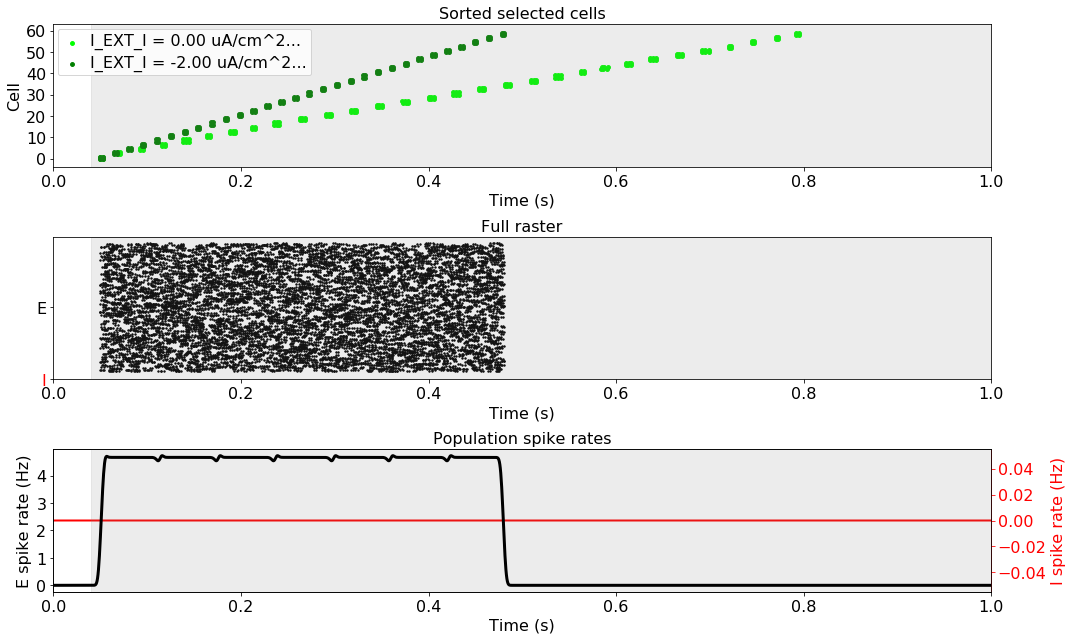

In [8]:
# make plots
X_RASTER = np.linspace(0, rslt.ntwk.x.max(), 30)
EPOCH = (.04, 1.)

colors=np.zeros(len(X_RASTER))
cmap='inferno'
nearest=2
epoch=(0, 1)
smoothness=4
fig_size=(15, 9)

fig, axs = plt.subplots(3, 1, figsize=fig_size, tight_layout=True)

for rslt, c in zip(rslts, rslt_c):
    # get ordered idxs of Es to plot
    e_mask = rslt.ntwk.types_r == 'E'
    x = rslt.ntwk.x[e_mask]

    ## loop through (x, y) pairs and add idxs of nearest Es
    e_idxs = get_idxs_nearest(X_RASTER, x, nearest) 

    # get all spks for selected Es
    spks_e_chosen = rslt.spks[:, e_idxs]

    # get desired time window
    if epoch == 'replay':
        start = 0
        end = rslt.schedule['D_SMLN']
    elif isinstance(epoch, tuple):
        start = epoch[0]
        end = epoch[1]

    t_mask = (start <= rslt.t) & (rslt.t < end)
    t_start = rslt.t[t_mask][0]

    spk_t_idxs, es = spks_e_chosen[t_mask].nonzero()
    spk_ts = spk_t_idxs * rslt.s['DT'] + t_start

    ## spks
    axs[0].scatter(spk_ts, es, c=c, s=15, vmin=0, vmax=1, cmap=cmap)

axs[0].set_xlim(0, rslt.t[-1])
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Cell')
axs[0].set_title('Sorted selected cells')
axs[0].legend(['I_EXT_I = {:.2f} uA/cm^2...'.format(i_ext_i_*1e6) for i_ext_i_ in i_ext_i])

set_font_size(axs[0], 16)

rslt = rslts[-1]

# Es
## get spks
spks_e = rslt.spks[:, :rslt.m['N_E']]

## raster
t_idxs_spks_e, nrn_spks_e = spks_e.nonzero()
t_spks_e = t_idxs_spks_e * rslt.dt

axs[1].scatter(t_spks_e, nrn_spks_e, s=2, c='k')

# population firing rate
axs[2].plot(rslt.t, smooth(spks_e.sum(axis=1) / (rslt.dt * rslt.m['N_E']), smoothness), c='k', lw=3)
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('E spike rate (Hz)')
axs[2].set_title('Population spike rates')

# Is
# get spks
spks_i = rslt.spks[:, -rslt.m['N_I']:]

# raster
t_idxs_spks_i, nrn_spks_i = spks_i.nonzero()
t_spks_i = t_idxs_spks_i * rslt.dt

axs[1].scatter(t_spks_i, -(1 + nrn_spks_i), s=2, c='r')
axs[1].set_yticks([-rslt.m['N_I']/2, rslt.m['N_E']/2])
axs[1].set_yticklabels(['I', 'E'])
axs[1].set_xlabel('Time (s)')
axs[1].set_title('Full raster')

for tick_label, color in zip(axs[1].get_yticklabels(), ['r', 'k']):
    tick_label.set_color(color)

# inh population average
ax_2_twin = axs[2].twinx()
ax_2_twin.plot(rslt.t, smooth(spks_i.sum(axis=1) / (rslt.dt * rslt.m['N_I']), smoothness), c='r', lw=2)
ax_2_twin.set_ylabel('I spike rate (Hz)')

axs[2].set_zorder(ax_2_twin.get_zorder() + 1)
axs[2].patch.set_visible(False)

set_color(ax_2_twin, 'r')

for ax in list(axs[1:]) + [ax_2_twin]:
    ax.set_xlim(0, rslt.t[-1])
    set_font_size(ax, 16)
    
axs[0].axvspan(*EPOCH, color='gray', alpha=0.15)
axs[1].axvspan(*EPOCH, color='gray', alpha=0.15)
axs[2].axvspan(*EPOCH, color='gray', alpha=0.15);